# Exercise 3

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from tqdm import trange, tqdm

In [2]:
#needed when running things on apple GPU
#pip install torch --upgrade


In [3]:
#need to update torchvision too
#pip install --upgrade torchvision

In [5]:
def get_device():
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.mps.is_available():
        device = "mps"
    return device

In [40]:
device = get_device()
print(f"Using device: {device}")

Using device: mps


## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [41]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """

    criterion = F.nll_loss # negative log likelihood loss here

    # Use GPU if available
    device = get_device()
    model.to(device)

    # TODO: set the model to train mode
    model.train()
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for batch_idx,item in enumerate(train_loader):
        # get the images and the truth labels
        images, truth_labels = item
        images, truth_labels = images.to(device), truth_labels.to(device)

        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        # TODO: run the network
        outputs = model(images)
        # TODO: compute negative log likelihood loss
        loss = criterion(outputs,truth_labels)
        # TODO: do backpropagation
        loss.backward()
        # TODO: optimize
        optimizer.step() # update the weights

        # TODO: print current loss for every nth ("log_interval"th) iteration
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(images)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [59]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            # transfer to GPU
            data = data.to(device)
            target = target.to(device)
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first n images
            img_idx = 0
            data = data.cpu().numpy()
            
            #while plotted < 100 and img_idx < data.shape[0]:
            while plotted < 100 and img_idx < data.shape[0]:# i reduced the number of plots
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [43]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self, layer_size_list=[784, 200, 100, 60, 30, 10]): # add the dropout probability here as well
        super(FCNet1, self).__init__()
        self.layer_size_list = layer_size_list
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.linear_layers = nn.ModuleList()
        for i in range(len(self.layer_size_list) - 1):
            self.linear_layers.append(
                nn.Linear(self.layer_size_list[i], self.layer_size_list[i + 1])
            )
    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)# This would reshape input from (batch_size, 1, 28, 28) to (batch_size, 784)
        
        # TODO: run network layers
        for layer in self.linear_layers[:-1]:
            x = torch.sigmoid(layer(x))
        # Apply the final layer (no activation)
        x = self.linear_layers[-1](x)

        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)

        return output

In [44]:
class FCNet2(nn.Module):
    def __init__(self, layer_size_list=[784, 200, 100, 60, 30, 10]):# add dropout later
        super(FCNet2, self).__init__()

        self.layer_size_list = layer_size_list
        
        self.linear_layers = nn.ModuleList() # this is list of linear layer
        for i in range(len(self.layer_size_list) - 1):
            self.linear_layers.append(
                nn.Linear(self.layer_size_list[i], self.layer_size_list[i + 1])
            )
    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)# This would reshape input from (batch_size, 1, 28, 28) to (batch_size, 784)
        
        # TODO: run network layers
        for layer in self.linear_layers[:-1]:
            x = F.relu(layer(x))
        # Apply the final layer (no activation)
        x = self.linear_layers[-1](x)

        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)

        return output

In [45]:
class FCNet3(nn.Module):
    def __init__(self, layer_size_list=[784, 200, 100, 60, 30, 10]):

        super(FCNet3, self).__init__()

        self.layer_size_list = layer_size_list

        self.linear_layers = nn.ModuleList() # this is list of linear layer
        self.batchnorm_layers = nn.ModuleDict() # list of BN layer
        
        for i in range(len(self.layer_size_list) - 1):
            self.linear_layers.append(
                nn.Linear(self.layer_size_list[i], self.layer_size_list[i + 1])
            )
            if i==0 or i==2:
                self.batchnorm_layers[str(i)]=nn.BatchNorm1d(self.layer_size_list[i + 1])

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)# This would reshape input from (batch_size, 1, 28, 28) to (batch_size, 784)

        # TODO: run network layers
        for i in range(len(self.linear_layers)-1):
            x=self.linear_layers[i](x)
            # apply BN layer to 1st and 3rd layer
            if i==0 or i==2:
                x=self.batchnorm_layers[str(i)](x)
            # apply activation function
            x = F.relu(x)
        # Apply the final layer (no activation)
        x = self.linear_layers[-1](x)

        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)

        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

Ans: 

Note these formulae:

1. For a simple kernel and stride based donwsampling:
* O = ((W - K + 2P) / S) + 1

Where:

* O is the output size
* W is the input size (width or height)
* K is the kernel size
* P is the padding
* S is the stride

2. For maxpooling based downsampling:
* O= $\left \lfloor\frac{(W + 2P - Dialation \times (k-1)-1 )}{S} +1 \right \rfloor$

Dilation is 1 for maxpooling 

In [46]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)  # 28x28 -> 26x26
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2) # 26x26 -> 12x12

        # Flattened size after conv2: 64 * 12 * 12 = 9216
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        # Conv layers with ReLU
        x = F.relu(self.conv1(x))  # 1x28x28 -> 32x26x26
        x = F.relu(self.conv2(x))  # 32x26x26 -> 64x24x24

        # Flatten
        x = x.view(x.size(0), -1)  # batch x 9216

        # Fully connected layers with ReLU
        x = F.relu(self.fc1(x))    # 9216 -> 128
        x = self.fc2(x)            # 128 -> 10

        # Log softmax for class probabilities
        output = F.log_softmax(x, dim=1)
        
        return output

In [47]:
class ConvNet2(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    Batch normalisation after 1CNN and 1FC layer
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet2, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)   # 28x28 -> 26x26
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm after conv1

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)  # 26x26 -> 12 x 12

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)  # BatchNorm after first FC
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv layer 1 + BN + ReLU
        x = F.relu(self.bn1(self.conv1(x)))   # 1x28x28 -> 32x26x26
        # Conv layer 2 + ReLU
        x = F.relu(self.conv2(x))             # 32x26x26 -> 64x12x12
        # Flatten
        x = x.view(x.size(0), -1)             # batch x 9216
        # FC layer 1 + BN + ReLU
        x = F.relu(self.bn_fc1(self.fc1(x)))  # 9216 -> 128
        # FC layer 2
        x = self.fc2(x)                       # 128 -> 10
        # LogSoftmax
        output = F.log_softmax(x, dim=1)

        return output


If we choose k=4,P=0, Dilation=1, and stride =3 for input image of W=26, then :

O=((26+0-4)/2)+1 => O = 11 + 1 = 12!

In [48]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        
        # TODO: initialize network layers
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3)  # 28x28 -> 26x26
        self.maxpool1 = nn.MaxPool2d(kernel_size=4, stride=2) # 26x26 -> 12x12

        # Flattened size after conv2: 64 * 12 * 12 = 9216
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        # Conv layers with ReLU
        x = F.relu(self.conv1(x))  # 1x28x28 -> 32x26x26
        x = F.relu(self.maxpool1(x))  # 32x26x26 -> 64x24x24

        # Flatten
        x = x.view(x.size(0), -1)  # batch x 9216

        # Fully connected layers with ReLU
        x = F.relu(self.fc1(x))    # 9216 -> 128
        x = self.fc2(x)            # 128 -> 10

        # Log softmax for class probabilities
        output = F.log_softmax(x, dim=1)
        
        return output

### Hyperparameters and DataLoader

In [49]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 2#10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = False#torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

### Fully connected networks

In the code below, IDK why when I keep `validate()` function, the kernel keeps on crashing on my laptop, thus meanwhile I have removed the validation function in the code below. (note that this code was in already present in the code, in the cell above, so we cannot simply comment `validate` function in the final solution.).


I ran script in google colab and it worked quite well. try it in your systems as well. if everything works well, then change the number of epochs to 10 in the cell above.

Epochs:   0%|                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.349570
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.289040
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.321350
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.298862
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.286941
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.310910
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.108419
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.710090
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.561748
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.628112

Test set: Average loss: 1.4917, Accuracy: 4168/10000 (41.68%)



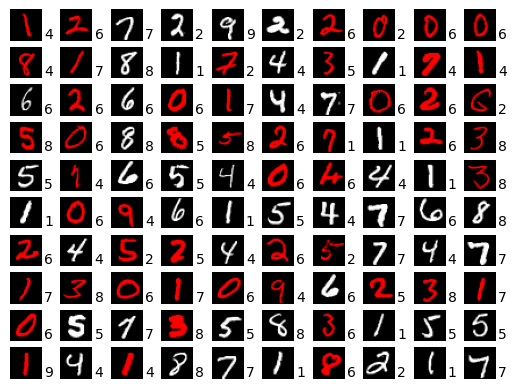

Epochs:  50%|████████████████████████████████████████████████████████████████████████████████                                                                                | 1/2 [00:08<00:08,  8.78s/it]

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.458652
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.482986
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.181849
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.254978
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.910884
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.842176
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.969876
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.756260
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.538537
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.496350

Test set: Average loss: 0.5057, Accuracy: 8893/10000 (88.93%)



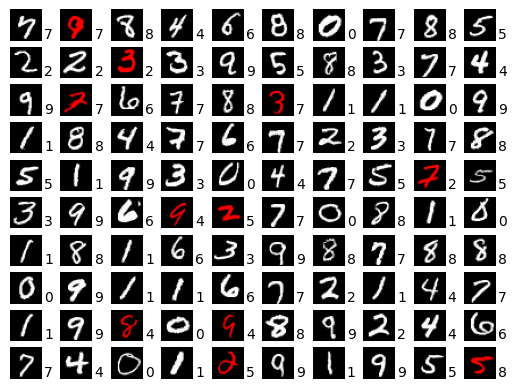

Epochs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.59s/it]


In [60]:
model = FCNet1()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in trange(1, epochs + 1, desc="Epochs"):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    # I think there is some problem in the validate model
    scheduler.step()
    
    #torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306138
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.407198
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.275068
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.271476
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.420376
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.311746
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.107792
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.092299
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.175182
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.092032

Test set: Average loss: 0.1306, Accuracy: 9606/10000 (96.06%)



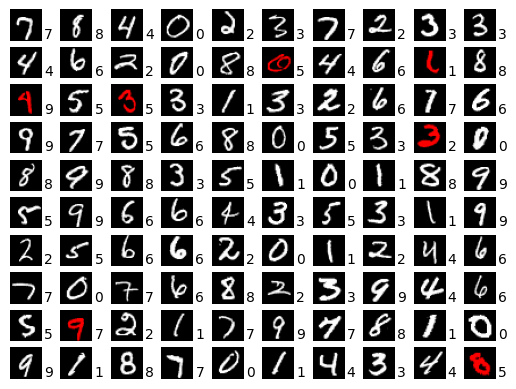

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.108683
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.075565
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.005414
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.023223
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.297188
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.059294
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.040511
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.036863
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.039719
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.336639

Test set: Average loss: 0.0943, Accuracy: 9750/10000 (97.50%)



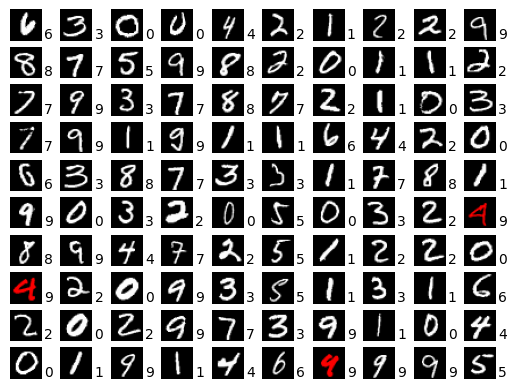

In [61]:
model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader) 
    scheduler.step()
    
    
    #torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.329369
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.280087
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.119491
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.139760
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.153795
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.168404
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.140072
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.103269
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.047572
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.214785

Test set: Average loss: 0.1126, Accuracy: 9658/10000 (96.58%)



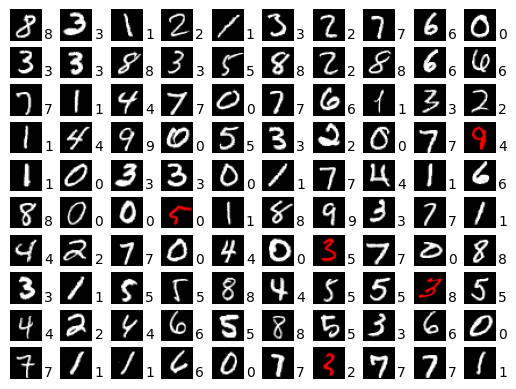

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.174092
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.138897
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.124640
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.021097
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.084455
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.113561
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.136615
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.042442
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.050393
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.059465

Test set: Average loss: 0.0707, Accuracy: 9779/10000 (97.79%)



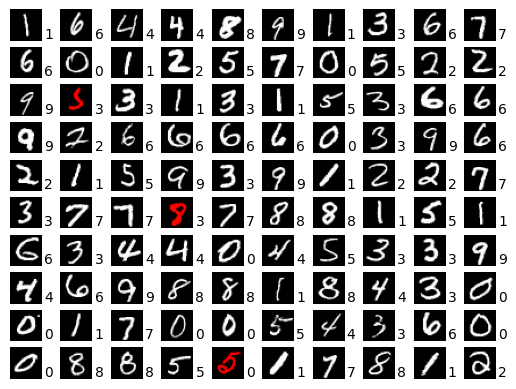

In [62]:
model = FCNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    #torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

### Running CNN networks

Epochs:   0%|                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307154
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.115457
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.050098
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.312514
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.065634
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.051649
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.148507
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.033258
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.025488
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.058676

Test set: Average loss: 0.0428, Accuracy: 9857/10000 (98.57%)



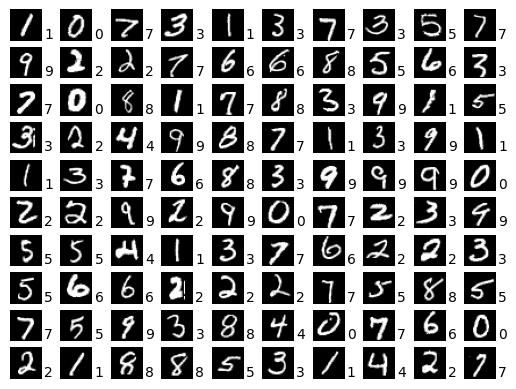

Epochs:  50%|████████████████████████████████████████████████████████████████████████████████                                                                                | 1/2 [00:09<00:09,  9.13s/it]

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.016736
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.099411
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.072132
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.002458
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.073596
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.009474
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.001236
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.002331
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.054600
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.026355

Test set: Average loss: 0.0437, Accuracy: 9855/10000 (98.55%)



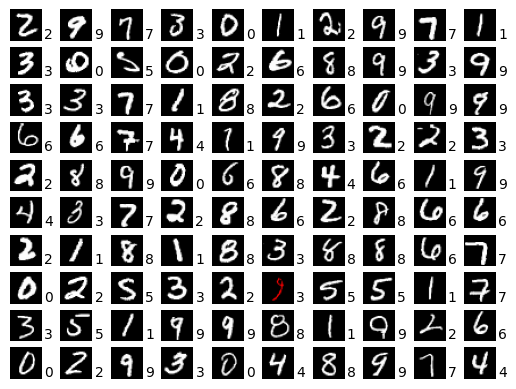

Epochs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.06s/it]


In [63]:
model = ConvNet1()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in trange(1, epochs + 1, desc="Epochs"):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    # I think there is some problem in the validate model
    scheduler.step()
    
    #torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

Epochs:   0%|                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.372457
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.181992
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.111362
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.058613
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.077932
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.054777
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.143298
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.039219
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.061640
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.054210

Test set: Average loss: 0.0334, Accuracy: 9891/10000 (98.91%)



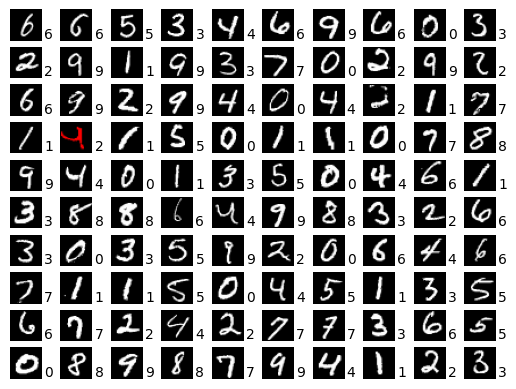

Epochs:  50%|████████████████████████████████████████████████████████████████████████████████                                                                                | 1/2 [00:10<00:10, 10.21s/it]

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.003417
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.006836
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.009867
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.002434
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.087364
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.003250
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.049967
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.007596
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.007245
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.013033

Test set: Average loss: 0.0310, Accuracy: 9899/10000 (98.99%)



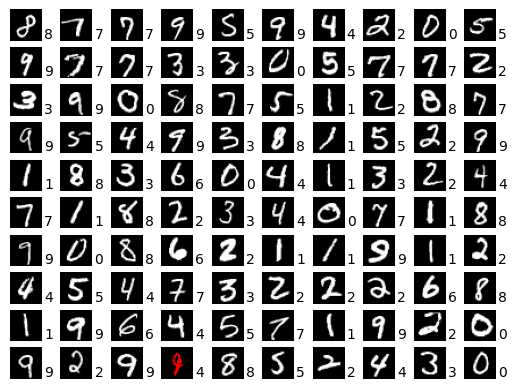

Epochs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:20<00:00, 10.14s/it]


In [64]:
model = ConvNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in trange(1, epochs + 1, desc="Epochs"):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    # I think there is some problem in the validate model
    scheduler.step()
    
    #torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

Epochs:   0%|                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.357074
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.394811
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.298587
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.089303
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.101074
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.068005
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.116861
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.043741
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.118262
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.099399

Test set: Average loss: 0.0755, Accuracy: 9761/10000 (97.61%)



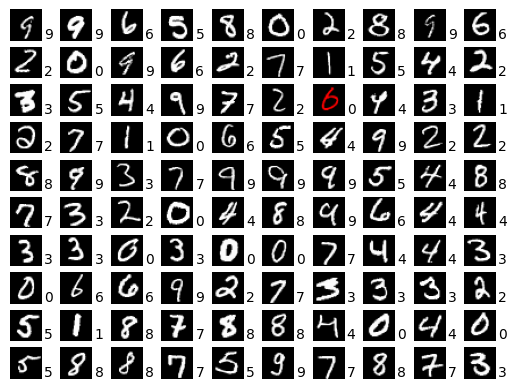

Epochs:  50%|████████████████████████████████████████████████████████████████████████████████                                                                                | 1/2 [00:08<00:08,  8.80s/it]

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.063029
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.077531
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.042701
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.007974
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.004411
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.020004
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.069543
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.130962
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.026272
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.008309

Test set: Average loss: 0.0420, Accuracy: 9865/10000 (98.65%)



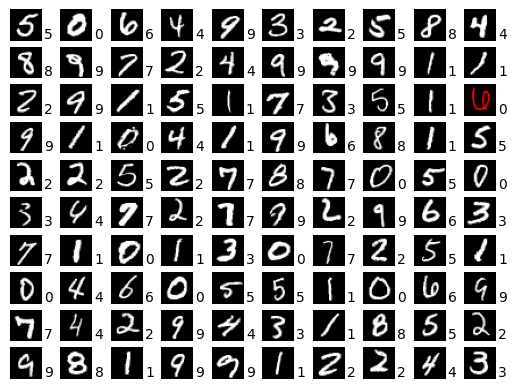

Epochs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.74s/it]


In [65]:
model = ConvNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in trange(1, epochs + 1, desc="Epochs"):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    # I think there is some problem in the validate model
    scheduler.step()
    
    #torch.save(model.state_dict(), "models/mnist/checkpoint.pt")